In [1]:
import sys
sys.path.append("clean/RecSys/code/")  # for lightning env
sys.path.append("../RecSys/code/")  # locally

import warnings
warnings.filterwarnings("ignore")  # going to depreciate warnings, provided conda env works

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from transformers import AutoTokenizer, MT5ForConditionalGeneration
import torch

# tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
# model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small", output_attentions=True)
# model

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from dataclasses import dataclass

@dataclass
class ArgsVal:
    dataset: str = "demo"
    batch_size: int = 1
    num_workers: int = 4
    T: int = 4  # number of previous articles to consider in the prompt
    datafraction: float = 1.0  # how much of entire dataset to use
    old: bool = True  # load checkpoints for model and not via modelwrapper
    from_checkpoint: str = "checkpoints/model_0.0001.pth"  # path to checkpoint locally
    model: str = "CG"  # conditional generation
    backbone: str = "google/mt5-small"
    tokenizer: str = "google/mt5-small"
    evaltrain: bool = False  # allows for evaluation on training set
    use_QA_model: bool = False

@dataclass
class ArgsTrain(ArgsVal):
    evaltrain: bool = True  # allows for evaluation on training set

argsval = ArgsVal()
argstrain = ArgsTrain()

In [9]:

tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
# model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small", output_attentions=True)
# model

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [11]:
# load model
from models.get_model import get_model

model_val = get_model(argsval)
model_train = get_model(argstrain)

<All keys matched successfully>
<All keys matched successfully>


In [12]:
# choose the prompt to use
# the provided checkpoints was trained using subtitles
from utils.prompt_templates import create_prompt_subtitles

In [13]:
# %cd clean/RecSys/code
%cd ../code

c:\Users\maart\Documents\RecSys\RecSys\code


In [14]:
# create the dataset
from data.dataloader import EkstraBladetDataset

# split sets output form of model
data_val = EkstraBladetDataset(argsval, create_prompt_subtitles, split="validation")
data_train = EkstraBladetDataset(argstrain, create_prompt_subtitles, split="validation")

In [25]:
# the model cannot process lists of strings
# the collator tokenizes these inputs and creates tensors
from collators import CollatorUnderstand
from torch.utils.data import DataLoader

# tokenizer = AutoTokenizer.from_pretrained(argsval.tokenizer)
collator = CollatorUnderstand(tokenizer)
dl_val = DataLoader(data_val, batch_size=1, collate_fn=collator, shuffle=False)
dl_train = DataLoader(data_train, batch_size=1, collate_fn=collator, shuffle=False)

In [26]:
# prompt_input_ids: tokenized prompts
# prompt_attention_mask: make each element in the batch as long as the longest tokenized prompt, mask padding tokens
# decoder_start: tokenized 'ja / nej' for CG model
next(iter(dl_val))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'prompt_input_ids': tensor([[  642, 36428,   588,  ...,     0,     0,     0],
         [  642, 36428,   588,  ...,     0,     0,     0],
         [  642, 36428,   588,  ...,     0,     0,     0],
         [  642, 36428,   588,  ...,     0,     0,     0],
         [  642, 36428,   588,  ...,  2794,   271,     1],
         [  642, 36428,   588,  ...,     0,     0,     0]]),
 'prompt_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'decoder_start': tensor([[ 432,  259,  275, 3810,    1],
         [ 432,  259,  275, 3810,    1],
         [ 432,  259,  275, 3810,    1],
         [ 432,  259,  275, 3810,    1],
         [ 432,  259,  275, 3810,    1],
         [ 432,  259,  275, 3810,    1]]),
 'targets': [0, 0, 0, 0, 0, 1],
 'categories': ['nyheder',
  'nationen',
  'sport',
  'nyheder',
  'nyheder',
  'forbrug',

In [27]:
import numpy as np

In [28]:
it_val = iter(dl_val)

In [29]:
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small", output_attentions=True)
model.base_model.load_state_dict(torch.load('C:/Users/maart/Documents/RecSys/RecSys/code/checkpoints/model_0.0001.pth', map_location=torch.device('cuda')))



<All keys matched successfully>

## Logits Analysis

In [30]:
example = next(it_val)
outputs = model(input_ids=example['prompt_input_ids'], attention_mask=example['prompt_attention_mask'], decoder_input_ids=example['decoder_start'])

# Determine the token IDs for 'ja' and 'nej'
ja_token_id = tokenizer.convert_tokens_to_ids("ja")
nej_token_id = tokenizer.convert_tokens_to_ids("nej")

# Specify the positions in the sequence where 'ja' and 'nej' are expected
ja_position = 0  # index for 'ja'
nej_position = 3  # index for 'nej'

logits = outputs.logits
ja_logits = logits[:, ja_position, :]  # shape: [batch_size, vocab_size]
nej_logits = logits[:, nej_position, :]  # shape: [batch_size, vocab_size]

# Extract specific logits for 'ja' and 'nej' tokens from the vocabulary
ja_logit_values = ja_logits[:, ja_token_id]  # shape: [batch_size]
nej_logit_values = nej_logits[:, nej_token_id]  # shape: [batch_size]

# Convert logits to probabilities using softmax
ja_probs = torch.softmax(ja_logits, dim=-1)[:, ja_token_id]  # shape: [batch_size]
nej_probs = torch.softmax(nej_logits, dim=-1)[:, nej_token_id]  # shape: [batch_size]

# Store 'ja' and 'nej' values in separate lists for all sentences in the batch
ja_values_list = ja_probs.tolist()
nej_values_list = nej_probs.tolist()

print("JA values for all sentences in the batch:", ja_values_list)
print("NEJ values for all sentences in the batch:", nej_values_list)


JA values for all sentences in the batch: [4.1305972314428785e-13, 3.647953521288688e-13, 3.912374710226402e-14, 1.0561321782398547e-13, 1.7205538006153688e-14, 2.6985214735507357e-13]
NEJ values for all sentences in the batch: [2.620094625201824e-13, 2.3046964185181873e-13, 7.440838852186549e-13, 3.3476211169433667e-13, 4.5438262527564e-13, 3.2670646244771506e-13]


In [57]:
def extract_probs(outputs, ja_position, nej_position, ja_token_id, nej_token_id):
    # Extract logits from the model outputs
    logits = outputs.logits
    ja_logits = logits[:, ja_position, :]  # shape: [batch_size, vocab_size]
    nej_logits = logits[:, nej_position, :]  # shape: [batch_size, vocab_size]

    # Extract specific logits for 'ja' and 'nej' tokens from the vocabulary
    ja_logit_values = ja_logits[:, ja_token_id]  # shape: [batch_size]
    nej_logit_values = nej_logits[:, nej_token_id]  # shape: [batch_size]

    # Convert logits to probabilities using softmax
    ja_probs = torch.softmax(ja_logits, dim=-1)[:, ja_token_id]  # shape: [batch_size]
    nej_probs = torch.softmax(nej_logits, dim=-1)[:, nej_token_id]  # shape: [batch_size]

    return ja_probs, nej_probs

def evaluate_predictions(outputs, ja_position, nej_position, ja_token_id, nej_token_id, targets):
    ja_probs, nej_probs = extract_probs(outputs, ja_position, nej_position, ja_token_id, nej_token_id)

    # Determine model responses based on highest probability
    predictions = (ja_probs > nej_probs).long().tolist()

    # Compare with targets and store logits for correct and incorrect predictions
    correct_predictions = []
    wrong_predictions = []
    correct_logits = {'ja_logits': [], 'nej_logits': []}
    wrong_logits = {'ja_logits': [], 'nej_logits': []}

    for index, (pred, target) in enumerate(zip(predictions, targets)):
        if pred == target:
            correct_predictions.append(index)
            correct_logits['ja_logits'].append(ja_logits[index].tolist())
            correct_logits['nej_logits'].append(nej_logits[index].tolist())
        else:
            wrong_predictions.append(index)
            wrong_logits['ja_logits'].append(ja_logits[index].tolist())
            wrong_logits['nej_logits'].append(nej_logits[index].tolist())

    return correct_predictions, wrong_predictions, correct_logits, wrong_logits

input_tokens = tokenizer.convert_ids_to_tokens(example['prompt_input_ids'][0])

correct_predictions, wrong_predictions, correct_logits, wrong_logits = evaluate_predictions(outputs, ja_position, nej_position, ja_token_id, nej_token_id, example['targets'])

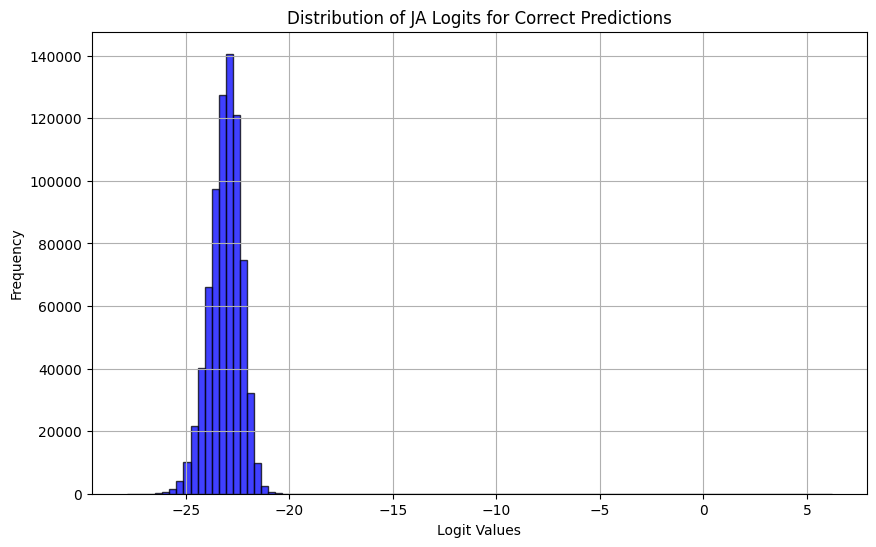

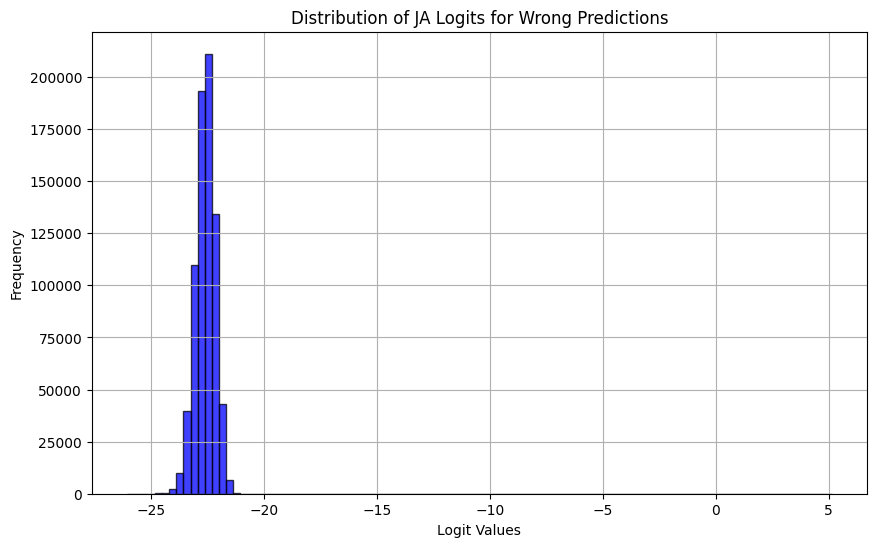

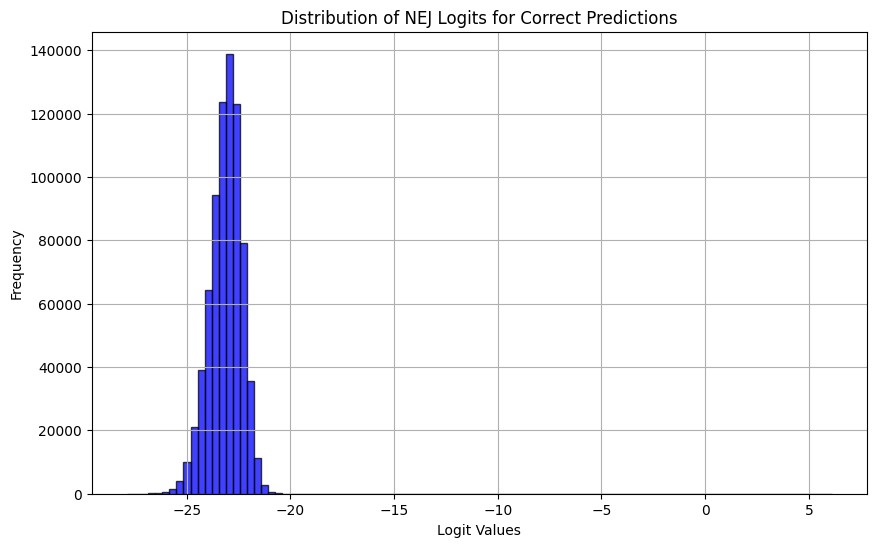

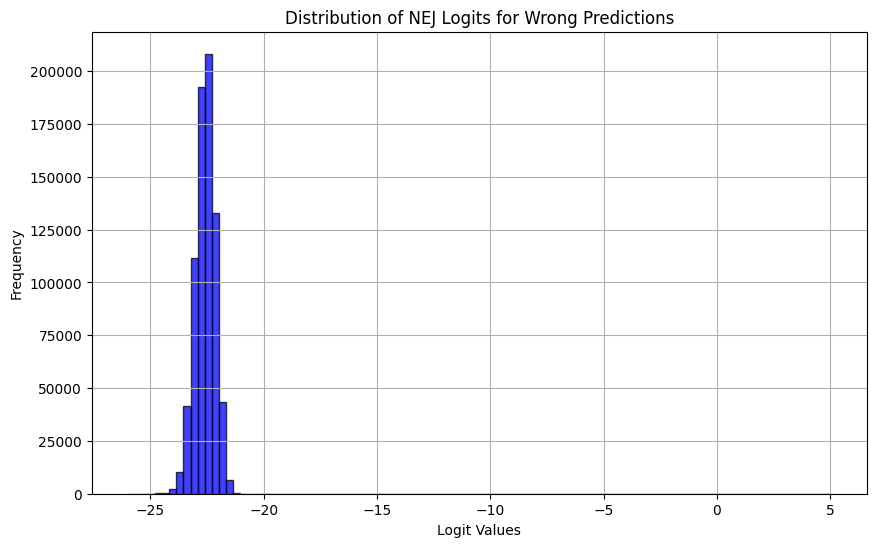

In [59]:
def plot_logit_distribution(logits, title, bins=100, range=None):
    # Convert logits to a tensor
    logits_tensor = torch.tensor(logits)
    
    # Flatten the tensor to get all logit values
    flattened_logits = logits_tensor.flatten().numpy()
    
    # Plot histogram of the logits
    plt.figure(figsize=(10, 6))
    plt.hist(flattened_logits, bins=100, alpha=0.75, color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Logit Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def evaluate_logit_distributions(correct_logits, wrong_logits):
    # Plot distributions for 'ja' logits
    plot_logit_distribution(correct_logits['ja_logits'], title='Distribution of JA Logits for Correct Predictions', bins=100, range=(-27, -18))
    plot_logit_distribution(wrong_logits['ja_logits'], title='Distribution of JA Logits for Wrong Predictions', bins=100, range=(-27, -18))
    
    # Plot distributions for 'nej' logits
    plot_logit_distribution(correct_logits['nej_logits'], title='Distribution of NEJ Logits for Correct Predictions', bins=100, range=(-27, -18))
    plot_logit_distribution(wrong_logits['nej_logits'], title='Distribution of NEJ Logits for Wrong Predictions', bins=100, range=(-27, -18))
    
evaluate_logit_distributions(correct_logits, wrong_logits)


## Compare trained to untrained model --> logits 

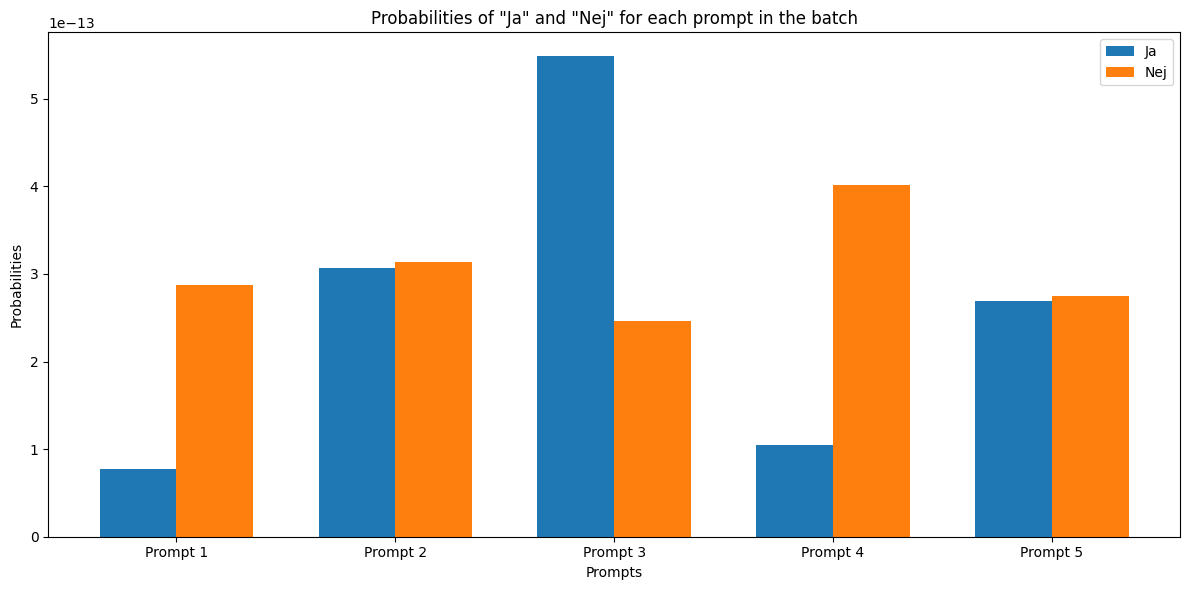

In [66]:
import matplotlib.pyplot as plt

# Plotting
batch_size = len(ja_values_list)
prompts = [f'Prompt {i+1}' for i in range(batch_size)]

plt.figure(figsize=(12, 6))

# Create a barplot
bar_width = 0.35
index = range(batch_size)

plt.bar(index, ja_values_list, bar_width, label='Ja')
plt.bar([i + bar_width for i in index], nej_values_list, bar_width, label='Nej')

plt.xlabel('Prompts')
plt.ylabel('Probabilities')
plt.title('Probabilities of "Ja" and "Nej" for each prompt in the batch')
plt.xticks([i + bar_width / 2 for i in index], prompts)
plt.legend()

plt.tight_layout()
plt.show()

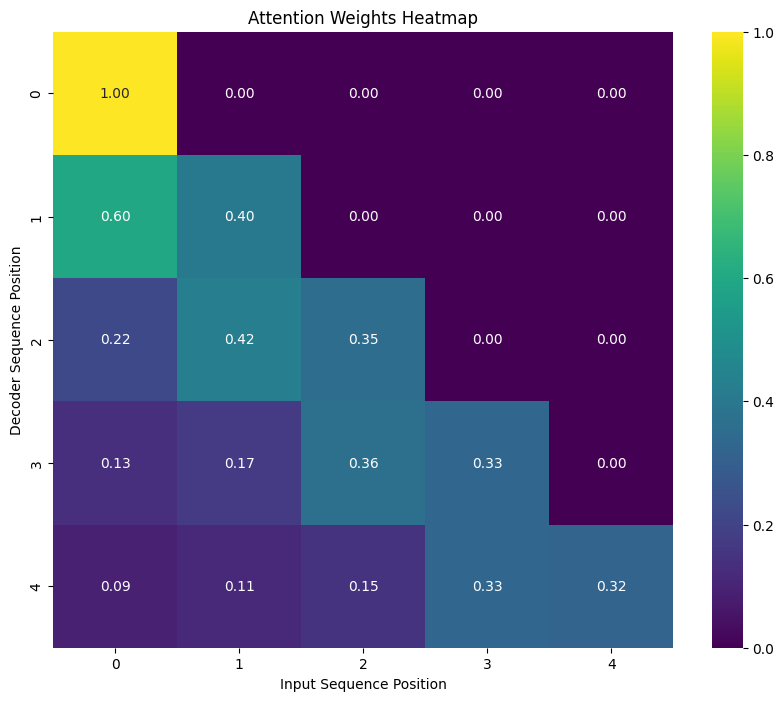

In [69]:
import seaborn as sns

attentions = outputs.decoder_attentions  # This will be a tuple of tensors

# Choose the attention weights from the last layer for visualization
# Each tensor in attentions is of shape (batch_size, num_heads, sequence_length, sequence_length)
last_layer_attention = attentions[-1]

# For simplicity, average the attention weights across all heads
avg_attention = last_layer_attention.mean(dim=1).detach().cpu().numpy()

# Plot the attention heatmap for the first example in the batch
example_index = 0

plt.figure(figsize=(10, 8))
sns.heatmap(avg_attention[example_index], annot=True, fmt=".2f", cmap="viridis")
plt.title("Attention Weights Heatmap")
plt.xlabel("Input Sequence Position")
plt.ylabel("Decoder Sequence Position")
plt.show()

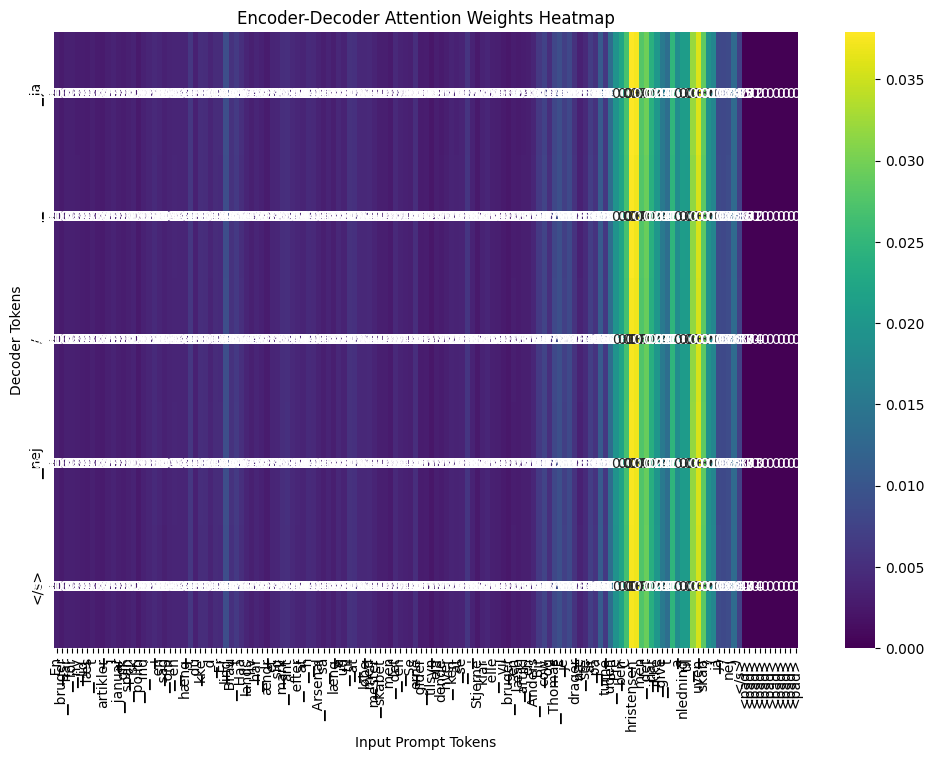

In [70]:
encoder_decoder_attention = outputs.cross_attentions[-1]  # shape: [batch_size, num_heads, decoder_seq_len, encoder_seq_len]

# For simplicity, average the attention weights across all heads
avg_attention = encoder_decoder_attention.mean(dim=1).detach().cpu().numpy()  # shape: [batch_size, decoder_seq_len, encoder_seq_len]

# Get the actual tokens from the input ids
input_tokens = tokenizer.convert_ids_to_tokens(example['prompt_input_ids'][0])
decoder_tokens = tokenizer.convert_ids_to_tokens(example['decoder_start'][0])

# Plot the attention heatmap for the first example in the batch
example_index = 0

plt.figure(figsize=(12, 8))
sns.heatmap(avg_attention[example_index], xticklabels=input_tokens, yticklabels=decoder_tokens, cmap="viridis", annot=True)
plt.title("Encoder-Decoder Attention Weights Heatmap")
plt.xlabel("Input Prompt Tokens")
plt.ylabel("Decoder Tokens")
plt.show()

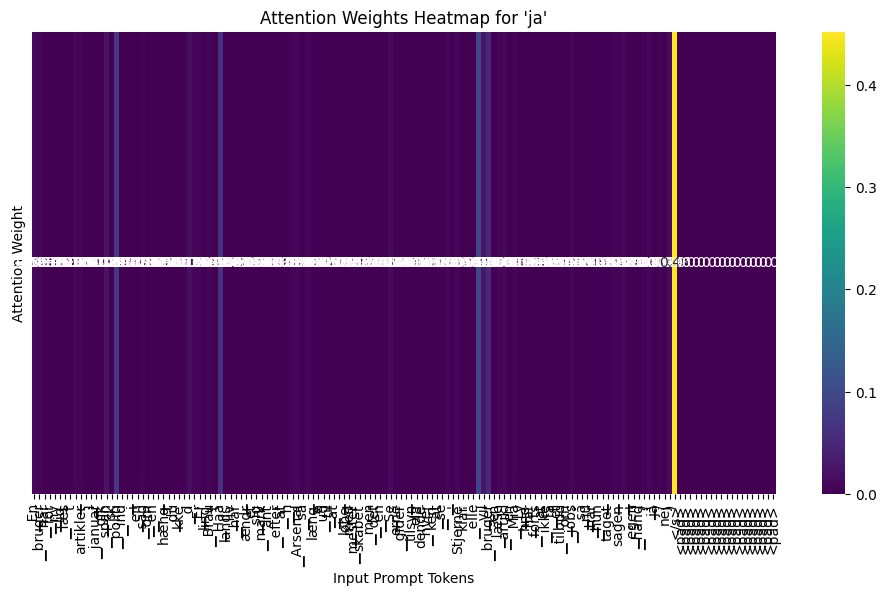

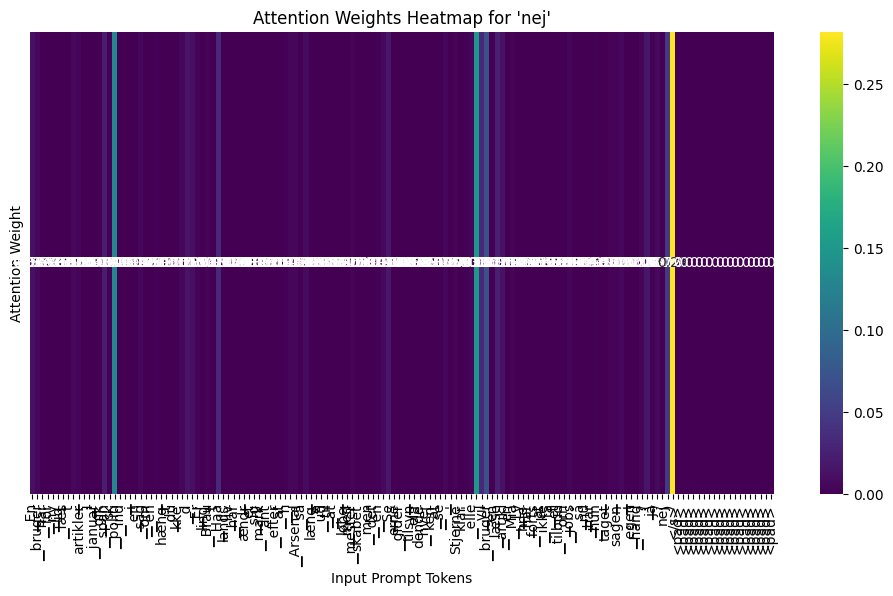

In [73]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, MT5ForConditionalGeneration

# Load the tokenizer and model with attention output enabled
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small", output_attentions=True)

# Example batch from iterator
example = next(it_val)

# Perform forward pass through the model
outputs = model(
    input_ids=example['prompt_input_ids'],
    attention_mask=example['prompt_attention_mask'],
    decoder_input_ids=example['decoder_start'],
    output_attentions=True
)

# Extract encoder-decoder attention weights from the outputs
encoder_decoder_attention = outputs.cross_attentions[-1]  # shape: [batch_size, num_heads, decoder_seq_len, encoder_seq_len]

# For simplicity, average the attention weights across all heads
avg_attention = encoder_decoder_attention.mean(dim=1).detach().cpu().numpy()  # shape: [batch_size, decoder_seq_len, encoder_seq_len]

# Get the actual tokens from the input ids
input_tokens = tokenizer.convert_ids_to_tokens(example['prompt_input_ids'][0])
decoder_tokens = tokenizer.convert_ids_to_tokens(example['decoder_start'][0])

# Positions for 'ja' and 'nej'
ja_position = 0  # assuming 'ja' is at position 0 in the decoder input
nej_position = 3  # assuming 'nej' is at position 3 in the decoder input

# Extract attention weights for 'ja' and 'nej'
ja_attention = avg_attention[0, ja_position]  # attention for 'ja' in the first example in the batch
nej_attention = avg_attention[0, nej_position]  # attention for 'nej' in the first example in the batch

# Plot attention for 'ja'
plt.figure(figsize=(12, 6))
sns.heatmap(ja_attention[None, :], xticklabels=input_tokens, cmap="viridis", annot=True)
plt.title("Attention Weights Heatmap for 'ja'")
plt.xlabel("Input Prompt Tokens")
plt.ylabel("Attention Weight")
plt.yticks([])
plt.show()

# Plot attention for 'nej'
plt.figure(figsize=(12, 6))
sns.heatmap(nej_attention[None, :], xticklabels=input_tokens, cmap="viridis", annot=True)
plt.title("Attention Weights Heatmap for 'nej'")
plt.xlabel("Input Prompt Tokens")
plt.ylabel("Attention Weight")
plt.yticks([])
plt.show()



In [76]:
from matplotlib import colors as mcolors
from IPython.core.display import display, HTML


# Normalize the attention weights for visualization
ja_attention_normalized = (ja_attention - np.min(ja_attention)) / (np.max(ja_attention) - np.min(ja_attention))
nej_attention_normalized = (nej_attention - np.min(nej_attention)) / (np.max(nej_attention) - np.min(nej_attention))

def visualize_attention(input_tokens, attention_weights, title):
    # Map attention weights to colors
    cmap = plt.get_cmap("YlGnBu")
    norm = mcolors.Normalize(vmin=0, vmax=1)

    # Create highlighted text with attention weights
    highlighted_text = ""
    for token, weight in zip(input_tokens, attention_weights):
        color = mcolors.to_hex(cmap(norm(weight)))
        highlighted_text += f'<span style="background-color:{color}">{token} </span>'

    # Display the highlighted text
    display(HTML(f"<div style='font-size: 16px; font-family: monospace;'>{highlighted_text}</div>"))

# Visualize attention for 'ja'
print('JA')
visualize_attention(input_tokens, ja_attention_normalized, title="Attention for 'ja'")

# Visualize attention for 'nej'
print('NEJ')
visualize_attention(input_tokens, nej_attention_normalized, title="Attention for 'nej'")

JA


NEJ


In [ ]:
scores = model_val.validation_step(example).cpu().numpy()

# scores = model_val(example['prompts']).cpu().numpy()
targets = np.array(example["targets"])
prompts = example["prompts"]

# # targets ranked according to model scores
order = np.argsort(scores)[::-1]
score_ranked_targets = np.take(targets, order)
scores, targets, prompts, score_ranked_targets

In [48]:
loss, pos_prob_yes, neg_prob_yes = model_val.train_step(example).cpu().numpy()
print(loss, pos_prob_yes, neg_prob_yes)

KeyError: 'pos_input_ids'

In [89]:
scores.logits

torch.Size([6, 5, 250112])

In [94]:
ja = tokenizer.encode('ja')[0] # == 0
nej = tokenizer.encode('nej')[0] # == 3
ja

432

In [99]:
# Example tensor of logits with shape [6, 5, 250112]
logits = scores.logits

# Extract the scores for the specific tokens
yes_scores = logits[..., ja]
no_scores = logits[..., nej]
# eos_scores = logits[..., eos_token_id]
# space_scores = logits[..., space_token_id]

print("Shapes of extracted scores:", yes_scores.shape, no_scores.shape)


Shapes of extracted scores: torch.Size([6, 5]) torch.Size([6, 5])


In [100]:
# Sum the scores across the sequence length
yes_scores_sum = yes_scores.sum(dim=1)
no_scores_sum = no_scores.sum(dim=1)


# Stack the summed scores into a single tensor for easier comparison
summed_scores = torch.stack([yes_scores_sum, no_scores_sum], dim=1)

# Get the highest score and its corresponding index
max_scores, max_indices = torch.max(summed_scores, dim=1)

# Map indices to tokens
index_to_token = {0: "yes", 1: "no"}

# Interpret the results
predicted_tokens = [index_to_token[idx.item()] for idx in max_indices]

for i, token in enumerate(predicted_tokens):
    print(f"Question {i+1}: Predicted token - {token}")


Question 1: Predicted token - no
Question 2: Predicted token - no
Question 3: Predicted token - no
Question 4: Predicted token - yes
Question 5: Predicted token - no
Question 6: Predicted token - no


In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

probs = F.softmax(logits, dim=-1)
probs.shape

tensor([[[2.7427e-14, 1.2946e-13, 1.7670e-14,  ..., 3.2840e-14,
          3.3012e-14, 5.5062e-15],
         [2.6964e-14, 1.3829e-13, 1.7392e-14,  ..., 3.2568e-14,
          3.2538e-14, 5.4419e-15],
         [2.8266e-14, 1.4220e-13, 1.8279e-14,  ..., 3.4190e-14,
          3.4307e-14, 5.7504e-15],
         [2.8675e-14, 1.4154e-13, 1.8501e-14,  ..., 3.4528e-14,
          3.4624e-14, 5.8233e-15],
         [2.7436e-14, 1.4154e-13, 1.7837e-14,  ..., 3.3237e-14,
          3.3363e-14, 5.6177e-15]],

        [[1.4501e-14, 8.9994e-14, 9.4326e-15,  ..., 1.7879e-14,
          1.7575e-14, 2.8769e-15],
         [1.4218e-14, 9.6505e-14, 9.2636e-15,  ..., 1.7697e-14,
          1.7281e-14, 2.8340e-15],
         [1.4856e-14, 9.9276e-14, 9.7077e-15,  ..., 1.8527e-14,
          1.8169e-14, 2.9851e-15],
         [1.5113e-14, 9.9292e-14, 9.8479e-15,  ..., 1.8746e-14,
          1.8375e-14, 3.0319e-15],
         [1.4384e-14, 9.8824e-14, 9.4495e-15,  ..., 1.7966e-14,
          1.7625e-14, 2.9076e-15]],

      

torch.Size([6, 5, 250112])

In [ ]:
# Get token IDs for 'ja' and 'nej'
ja_token_id = tokenizer.convert_tokens_to_ids("ja")
nej_token_id = tokenizer.convert_tokens_to_ids("nej")

# Extract probabilities for 'ja' and 'nej'
ja_probs = probs[:, :, ja_token_id]
nej_probs = probs[:, :, nej_token_id]

# Analyze the logits and their distribution
ja_logits = logits[:, :, ja_token_id]
nej_logits = logits[:, :, nej_token_id]

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.hist(ja_logits.detach().numpy().flatten(), bins=50, alpha=0.5, label='ja logits')
plt.hist(nej_logits.detach().numpy().flatten(), bins=50, alpha=0.5, label='nej logits')
plt.legend()
plt.title('Logits Distribution for ja and nej')
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.show()

# Inspect attention weights
attention_weights = outputs.decoder_attentions
print("Attention Weights:", attention_weights)

In [ ]:
# it_train = iter(dl_train)

In [ ]:
# example = next(it_train)
# scores = model_train.validation_step(example).cpu().numpy()
# targets = np.array(example["targets"])
# prompts = example["prompts"]

# # targets ranked according to model scores
# order = np.argsort(scores)[::-1]
# score_ranked_targets = np.take(targets, order)
# scores, targets, prompts, score_ranked_targets

(array([0.49515206, 0.5216051 , 0.42004386, 0.66117924, 0.54520535,
        0.71452135, 0.5508101 , 0.03665067, 0.5397415 , 0.2359618 ,
        0.7062714 ], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 ['En bruger har for nylig læst artikler: Anklagemyndighed ønsker grundlaget for fængsling udvidet i s, Politiet skred onsdag aften til anholdelse af en mand i Fæll, Konen efter afdøde Jørgen Haugen Sørensen, der var en af lan, Konen efter afdøde Jørgen Haugen Sørensen, der var en af lan, vil brugeren læse artiklen David Beckham havde både gave og rosende ord med til kong Charles, da de to forleden mødtes til en modebegivenhed i London? (ja/nej)\n',
  'En bruger har for nylig læst artikler: Anklagemyndighed ønsker grundlaget for fængsling udvidet i s, Politiet skred onsdag aften til anholdelse af en mand i Fæll, Konen efter afdøde Jørgen Haugen Sørensen, der var en af lan, Konen efter afdøde Jørgen Haugen Sørensen, der var en af lan, vil brugeren læse artiklen Går turen syd